# Bank Customer Churn Predictor 

## Project introduction
Customer retention is paramount to the survival, growth and development of a company. It helps forge strong and lasting relationships with existing customers which not only helps attract new ones, but also provides a steady source of income by increasing a customer's lifetime value. In fact, the probability of selling to an existing customer is around 60-70% whilst the chance of selling to a new prospect ranges from 5-20%. Acquiring new prospects is about 5 times more expensive than retaining existing customers. Finally, increasing customer retention by just 5% can increase profits by 25-95% [[1]](https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/).

Therefore, it is in the interest of a company or service to be able to determine, using historical data whether a customer will churn (not be retained/exit) in advance in order to take preemptive action and try to retain them. 

In this python notebook, I will attempt to build a model which outputs the likelihood of a customer exiting a bank using the bank customer churn prediction dataset from [Kaggle](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers). 

In [1]:
#imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import keras 
from keras.models import Sequential
from keras.layers import Dense


In [2]:
#gathering 
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Introduction to the dataset 
This dataset was downloaded from Kaggle and contains 14 metrics on 10 000 bank customers:

* Row number
* Customer ID 
* Customer surnamne 
* Credit score: a number between 300-850 which depicts their ability to repay debts. This higher this number is, the more attratctive the customer looks to potential lenders. 
* Customer geography (country) 
* Gender
* Age 
* Tenure: amount of time (in years) the account has been open.
* Balance
* Number of products
* If the customer has a credit card
* If the customer is an active member
* Customer estimated salary
* If the customer has closed his account/exited the bank

## Data cleaning

Checking if all datatypes are correct. 

In [4]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

It is apparent that not all columns are relevant with what we are trying to do. The ones that immediately come to mind are ```RowNumber```, ```CustomerID``` and ```Surname```, so we can drop these rows from the DataFrame. 

In [5]:
df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'],inplace = True)

Next we can decapitalise the column headers to slightly simplify the further steps. 

In [6]:
df.columns  = df.columns.str.lower()

## Exploratory data analysis 
In this section, the data will be explored to draw insights and assumptions for  model building will be checked. 

### Percent of customers who churned. 

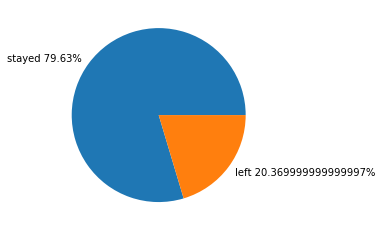

In [7]:
plt.pie(df['exited'].value_counts(), labels = ['stayed '+ str(sum(df['exited']==0)/df.shape[0] *100)+ '%', 'left ' +str(sum(df['exited']==1)/df.shape[0] *100)+ '%' ]);

About 80% of the customers in this dataset still have their account in the bank whilst 20% have churned. We note that there is a class imbalance in this dataset. 

### Credit Score

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


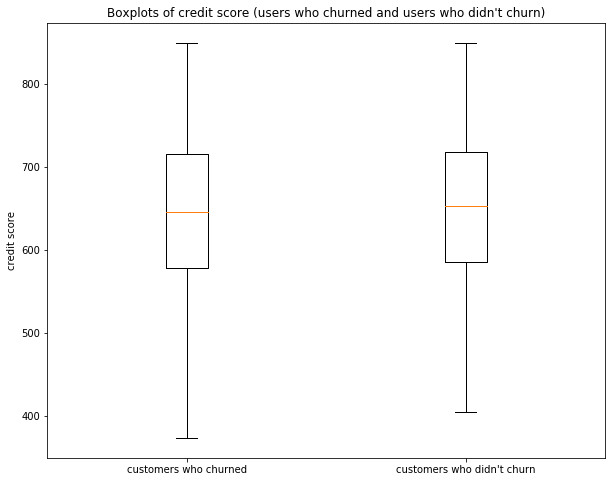

In [8]:
plt.figure(figsize=(10,8))
plt.ylabel('credit score')
plt.boxplot([df[df['exited']==1]['creditscore'],df[df['exited']==0]['creditscore']], labels = ['customers who churned', "customers who didn't churn"], showfliers= False );
plt.title("Boxplots of credit score (users who churned and users who didn't churn)");

This boxplot suggests that there isn't much of a difference in the credit score of customers who churned and who didn't.

### Gender

In [9]:
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [10]:
df.query('gender== "Female" & exited==1').shape[0], df.query('gender== "Male" & exited==1').shape[0]

(1139, 898)

We see that there are about 900 more male customers than female customers in this bank yet around 250 more females have left the bank. Is this just chance or is gender statistically significant in predicting whether a given customer will churn? 

### Age 

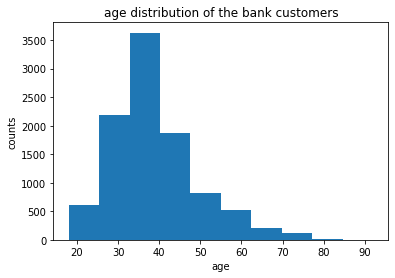

In [11]:
plt.xlabel('age')
plt.ylabel('counts')
plt.hist(df['age'], label =['age', 'counts']);
plt.title('age distribution of the bank customers');

Overall, the age distribution is somewhat normal (symmetric around the mean) with a slight skew to the left. 

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


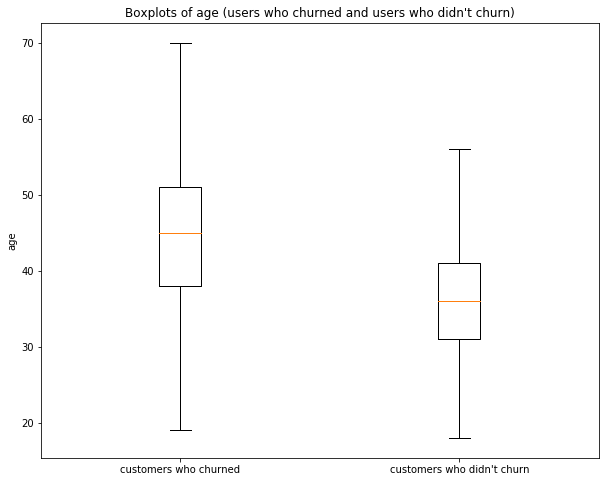

In [12]:
plt.figure(figsize=(10,8))
plt.ylabel('age')
plt.boxplot([df[df['exited']==1]['age'],df[df['exited']==0]['age']], labels = ['customers who churned', "customers who didn't churn"], showfliers= False );
plt.title("Boxplots of age (users who churned and users who didn't churn)");

These boxplots suggest that there might be a relationship between age and likelihood of churning. Indeed we see that customers who churned are generally older than those who didn't churn. 

### Active member

In [13]:
df['isactivemember'].value_counts()

1    5151
0    4849
Name: isactivemember, dtype: int64

In [14]:
df.query('isactivemember == 1 & exited== 1').shape[0], df.query('isactivemember == 0 & exited== 1').shape[0]

(735, 1302)

In this dataset, there is a similar amount of active and non active members. We note that a lot more inactive members have churned. 

### Remarks 
This quick EDA does seem to point out a to relationship between the different variables present in the dataset and whether a given customer has exited the bank. We could therefore use different machine learning methods to build a model that predicts if a customer will churn. 

### Preparing the data
* First, let's replace the observations in the categorical rows with dummies.
* Setting which columns of the dataframes are the variables and setting ```exited``` as the response variable. 
* Splitting the dataframe into training (75%) and testing (25%) datasets. 

In [15]:
#Getting dummies
gender =pd.get_dummies(df['gender'], drop_first = True)
geography = pd.get_dummies(df['geography'], drop_first= True )  #France used as reference category

#Covariates
covariates = [df.columns[i] for i in range(len(df.columns)-1)]
X = df[covariates]
X.drop(columns = ['geography', 'gender'], inplace = True)

#merge dummies into covariates 
X=pd.concat([X,geography,gender],axis=1)

#response
y= df.exited

#splitting the data train/test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Logistic regression 


This method is used for modelling a binary response (exited/stayed) by using a sigmoid function which maps any real number to a probability (between 0 and 1): $$f: \mathbb R \to (0,1), f(x) = \frac 1 {1+ e^{-x}}$$

A logistic model works under certain **assumptions** we make on our data, namely: 
* That the dependent variable be binary (this is true in our case) 
* That each observation is independent of each other - this can be hard to check but in this we can make this assumption as whether customer 1 has churned or not should not have an impact on the outcome of customer 2. 
* That there is little to no *multicollinearity* between the covariates. This is tricky to check, as there can be a relationship between ```estimatedsalary```and ```creditscore``` for example. However, we shall go ahead and assume that there is little to no multicollinearity in this dataset. 
* We are also assuming that there is a linear relationship between the log odds and the covariates: if $p$ is the probability of a customer churning, then we are saying that: $$\ln \left( \frac p {1-p} \right) = \beta_0 +\sum_{i=1}^n \beta_i x_i $$

* Finally logistic regression requires a large enough sample size. The 'rule of ten' is usually used as a guidline: number of observations $>$ 10. This criteria is satisfied in our case as we have 10,000 observations to work with.

The method used to estimate the regression coefficients here is [maximum likelihood estimation](https://www.univ-orleans.fr/deg/masters/ESA/CH/Chapter2_MLE.pdf). 


### Building the model
* Building a logistic regression model from our training dataset
* Getting the output from ```statsmodels.api```

In [16]:
logreg= sm.Logit(y_train, X_train).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.437821
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 exited   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7989
Method:                           MLE   Df Model:                           10
Date:                Sun, 29 Aug 2021   Pseudo R-squ.:                  0.1346
Time:                        11:00:30   Log-Likelihood:                -3502.6
converged:                       True   LL-Null:                       -4047.2
Covariance Type:            nonrobust   LLR p-value:                1.103e-227
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
creditscore        -0.0035      0.000    -16.487      0.000      -0.004      -0.003
age           

### Testing the model 
* Applying the model to our testing set
* Displaying the confusion matrix 
* Displaying the accuracy, precision and recall 

In [17]:
pred = list(map(round, logreg.predict(X_test)))

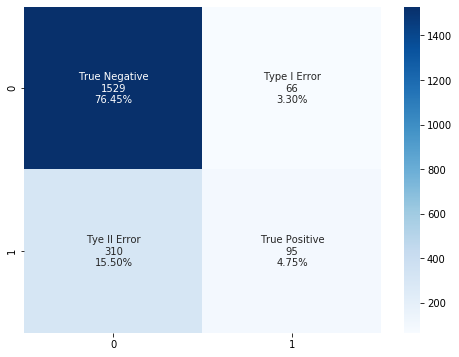

In [18]:
cnf_matrix = metrics.confusion_matrix(y_test, pred)
plt.figure(figsize= (8,6))
group_names = ['True Negative','Type I Error','Tye II Error','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [19]:
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

Accuracy: 0.812
Precision: 0.5900621118012422
Recall: 0.2345679012345679


### Analysing the model 

#### Summary 
First, the model returns and LLR p-value of $\approx 1.103 \times 10^{-227}$ which is very low and indicates that we have grounds to reject the null hypothesis $H_0$, which states that the predicted $y$ values from our model are no closer than $y$ values we would get by chance. Therefore, our model does explain some of the variability in the likelihood of a customer exiting the bank. 

Overall, most of the covariates have low p-values associated with them (<0.05) except for ```balance```(0.139), ```estimatedsalary``` (0.122) and the categorical covariate ```Spain``` (0.611, which is high!). I have chosen to keep these predictors in the model. We could consider removing ```Spain``` but this would make the interpreation of the coefficients for ```geography``` very tricky. 

#### Confusion matrix 
The confusing matrix seems to indicate that our model is powerful in deciding whether a person will **not churn** as it returned a Type I error rate (false positive) of$\approx$ 3.3% when applied to the testing set. Out of the 1605 people who did not churn, the model correctly identified 1529 of them. 

However, our model has a high Type II error rate (false negatives) of $\approx$15.5%. In fact, of the 405 customers who exited the bank in this dataset, our model was only able to correctly identify 95 of them! 

#### Accuracy, Precision and Recall
The model displays an accuracy of around 80, which in theory is a rather good number. This result is deceptive as our dataset contains a class imbalance (80% to 20%). When we look at our confusion matrix, we see that the model is not very good at identifying customers who exit the bank. 

Precison = $\frac{TP}{TP+FP}$. This metric quantifies the number of correct positive predictions made. It is the accuracy of minority class predicitions. Our precision is $\approx 0.6$ which is not high enough. 

Recall = $\frac{TP}{TP+FN}$. This metric quantifies the number of correct positive predictions made out of all possible positive predicitions. In our case, the recall is of $\approx 0.23$ which is extremely low and indicates that our model is not good at identifying customers who exit the bank. 

## Artificial Neural Network

Since our logistic regression model does not provide good results, we can try our luck with an artificial neural network. The input layer of our neural network will have 11 nodes (which correspond to each covariate in our dataset). Our output layer will have one node and will assign a probability (number between 0 and 1) to incoming data via the use of a **sigmoid function** (discussed above). The weights of the model will be adjusted during the training by the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) method.


First, we assume that our covariates are normally distributed: $X_i \sim N(\mu_i, \sigma_i^2)$, where $i$ represents the $i$th predictor.
Since the range of values these variables take is different, it makes sense to apply a standard normal transformation to our data: $$X_i = \frac{X_i- \mu_i}{\sigma_i} \sim N(0,1^2)$$

In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
#initialising the neural network
classifier = Sequential()

### The architecture (activation functions, hidden layers and nodes). 

#### Architecture
I have chosen a neural network with 1 input layer, one output layer and 3 hidden layers with 8,6 and 4 neurons in each one respectively. This choice was arbitrary. There is a way to determine the best architecture for an artificial neural network using hyperparameter optimisation, but I am quite new to this topic and wanted to keep it simple for my first project. 

The weights are initialised using the *'he'* method, developed by Kaming He, who is currently a research scientist at Facebook: the weights for each layer are generated in the following way: $$ w \sim N(0, \sqrt{\frac 2{n_l}}^2)$$

Where $n_l$ represents the amount of neurons in the $l$th layer. This weight initialisation method works well with ReLU and allows us to avoid the *vanishing and exploding grandient* problems which can occur during backpropagation. 

The weights at the output layer are generated with the *Glorot uniform distribution*: 

$$w \sim U \left [ -\frac{ {\sqrt 6}}{\sqrt{n_l +n_{l +1}}}, \frac{ {\sqrt 6}}{\sqrt{n_l +n_{l +1}}} \right]$$

#### Activation functions 
I have chosen to use the ReLU (rectified linear unit) activation function at each node of each layer (except for the output layer). This function is defined in the following way: $$ g: \mathbb R \to \mathbb R, g(x) = \max(0,x)$$

The advantage of using ReLU is that it can solve the *vanishing gradient*  problem which appears during the backpropagation phase of training when using a sigmoid activation function. The explanation is technical and requires an understanding of the multivariate chain rule and the fact that the first derivative of the sigmoid function: $$ f'(x) = \frac {e^{-x}}{(1+e^{-x})^2}$$ 

is such that $\forall x \in \mathbb R, 0< f'(x) <0.25$. 
More on this can be found [here](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).


In [22]:
#building the neural network

#input layer
classifier.add(Dense(8, kernel_initializer='he_uniform',activation='relu',input_dim = 11))

#hidden layers
classifier.add(Dense(6, kernel_initializer='he_uniform',activation='relu'))
classifier.add(Dense(4, kernel_initializer='he_uniform',activation='relu'))

#Output layer
classifier.add(Dense(1, kernel_initializer='glorot_uniform', activation = 'sigmoid'))


In [23]:
#Compiling and training the model
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
800/800 [==============================] - 2s 1ms/step - loss: 0.5078 - accuracy: 0.7635
Epoch 2/100
800/800 [==============================] - 1s 1ms/step - loss: 0.4331 - accuracy: 0.8074
Epoch 3/100
800/800 [==============================] - 1s 1ms/step - loss: 0.4130 - accuracy: 0.8131
Epoch 4/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3966 - accuracy: 0.8253
Epoch 5/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3807 - accuracy: 0.8425
Epoch 6/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3658 - accuracy: 0.8496
Epoch 7/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3524 - accuracy: 0.8554
Epoch 8/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3459 - accuracy: 0.8590
Epoch 9/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3417 - accuracy: 0.8606
Epoch 10/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3400 - accura

800/800 [==============================] - 2s 2ms/step - loss: 0.3237 - accuracy: 0.8659
Epoch 82/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3241 - accuracy: 0.8673
Epoch 83/100
800/800 [==============================] - 1s 2ms/step - loss: 0.3236 - accuracy: 0.8649
Epoch 84/100
800/800 [==============================] - 1s 2ms/step - loss: 0.3232 - accuracy: 0.8664
Epoch 85/100
800/800 [==============================] - 1s 2ms/step - loss: 0.3236 - accuracy: 0.8660
Epoch 86/100
800/800 [==============================] - 2s 2ms/step - loss: 0.3234 - accuracy: 0.8662
Epoch 87/100
800/800 [==============================] - 1s 2ms/step - loss: 0.3234 - accuracy: 0.8654
Epoch 88/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3233 - accuracy: 0.8670
Epoch 89/100
800/800 [==============================] - 1s 2ms/step - loss: 0.3233 - accuracy: 0.8656
Epoch 90/100
800/800 [==============================] - 1s 2ms/step - loss: 0.3239 - accuracy: 

In [24]:
#using the model on testing data
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

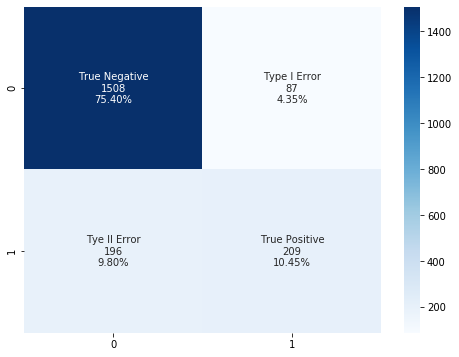

In [25]:
#confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize= (8,6))
group_names = ['True Negative','Type I Error','Tye II Error','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8585
Precision: 0.706081081081081
Recall: 0.5160493827160494


### Results 

Our ANN has been more successful in identifying the customers that are likely to exit the bank: detecting around 50% of them at the detriment of a slightly higher Type I error rate of just under 5%. 
This model would therefore be more useful to the people working at the bank than the logistic regression model. 
The neural network also has a higher accuracy, precision and recall than the logistc regression model. 

I believe both models could be improved by reducing the class imbalance in the dataset. Meanwhile, the bank can use this model now to prevent 50% of churn cases whilst they gather more data!